In [29]:
#!pip install --user model
#!pip search model
#import pandas as pd
#pd.__version__
!pip install pandas

You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
!conda-env list

/bin/sh: 1: conda-env: not found


In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from model import Model

In [10]:
t1 = pd.read_csv("table1-com-clima.csv")
t2 = pd.read_csv("table1-sem-clima.csv")
t3 = pd.read_csv("table2-colheita.csv")


In [12]:
print('table1-com-clima')
print(t1)
print('table1-sem-clima')
print(t2)
print('colheita')
print(t3)

table1-com-clima
     codcult  safra     datprev      e1      e2      e3      e4      e5  \
0         16      1  2010-09-16    1.89    1.26    0.63    0.00    0.00   
1         16      1  2010-10-08    0.13    0.00    0.00    0.00    0.00   
2         16      1  2010-10-15   12.08    0.13    0.00    0.00    0.00   
3         16      1  2010-10-22   47.40   12.08    0.13    0.00    0.00   
4         16      1  2010-10-29   79.06   47.39   14.40    0.00    0.00   
5         16      1  2010-11-05   97.17   79.07   47.40    0.00    0.00   
6         16      1  2010-11-12  100.01   97.17   79.07    0.00    0.00   
7         16      1  2010-11-19  100.00  100.00   97.16    0.00    0.00   
8         16      1  2010-11-26  100.00  100.00  100.00    0.00    0.00   
9         16      1  2010-12-03  100.00  100.00  100.00    0.00    0.00   
10        16      1  2010-12-10  100.00  100.00  100.00   14.40    0.00   
11        16      1  2010-12-17  100.00  100.00  100.00   45.93    0.00   
12      

In [13]:
print('table1-com-clima')
print(t1.describe())
print('table1-sem-clima')
print(t2.describe())
print('colheita')
print(t3.describe())

table1-com-clima
          codcult       safra          e1          e2          e3          e4  \
count  539.000000  539.000000  539.000000  539.000000  539.000000  539.000000   
mean    52.897959    9.630798   85.892672   81.499981   76.785826   40.228868   
std     49.161243    5.616877   30.646629   35.016696   38.749788   45.435382   
min     16.000000    0.000000    0.130000    0.000000    0.000000    0.000000   
25%     16.000000    5.000000   91.750000   81.130000   56.570000    0.000000   
50%     18.000000   10.000000  100.000000  100.000000  100.000000   10.890000   
75%    120.000000   14.000000  100.000000  100.000000  100.000000  100.000000   
max    120.000000   19.000000  131.530000  131.530000  131.530000  131.530000   

               e5          e6          e7      n7tmed     ...         p28tmin  \
count  539.000000  539.000000  539.000000  539.000000     ...      539.000000   
mean    27.304991    6.421429    0.159889   22.846660     ...       18.024656   
std     40

## Variáveis

In [21]:
pca = False
clima = False
graph = True
save_graph = True
printt = True

pca_variance = 0.8
folds = 5

if clima:
    t1 = pd.read_csv("table1-com-clima.csv")
else:
    t1 = pd.read_csv("table1-sem-clima.csv")

t2 = pd.read_csv("table2-colheita.csv")
t1.datprev = t1.datprev.astype('datetime64[ns]')
t2.datprev = t2.datprev.astype('datetime64[ns]')

## Funções

In [22]:
# Conversão data em dias para interpolação
def convert_dates_to_days(dates, start_date=None, name='Day'):
    if start_date:
        ts0 = pd.Timestamp(start_date).timestamp()
    else:
        ts0 = 0

    return ((dates.apply(pd.Timestamp.timestamp) - 
            ts0)/(24*3600)).rename(name)

def inverse_func(func, min, max, value, tol): 
    avgind = min+((max-min)/2)
    favg = func(avgind)
    
    if (favg == value) or (max-min <= tol):
        return avgind
    if favg > value:
        return inverse_func(func, min, avgind, value, tol)
    else:
        return inverse_func(func, avgind, max, value, tol)
        
def getPrazo(perc, saf, cult, t2):
    df = t2[(t2.safra == saf)&(t2.codcult==cult)]
    start_date = df.datprev.to_list()[0]
    x = convert_dates_to_days(df.datprev, start_date=start_date)
    y = df["colheita(%)"]
    
    if len(x)>3:
        func = interp1d(x, y, kind='cubic')
    elif len(x)>2:
        func = interp1d(x, y, kind='quadratic')
    elif len(x)>1:
        func = interp1d(x, y, kind='linear')
          
    daysadd = inverse_func(func, x.to_list()[0], x.to_list()[-1], perc, 1 )
    end_date = start_date + pd.DateOffset(days = int(daysadd))
    
    return end_date

## Algoritmo de Regressão

Estádios 1 - 1


AttributeError: 'Series' object has no attribute 'to_list'

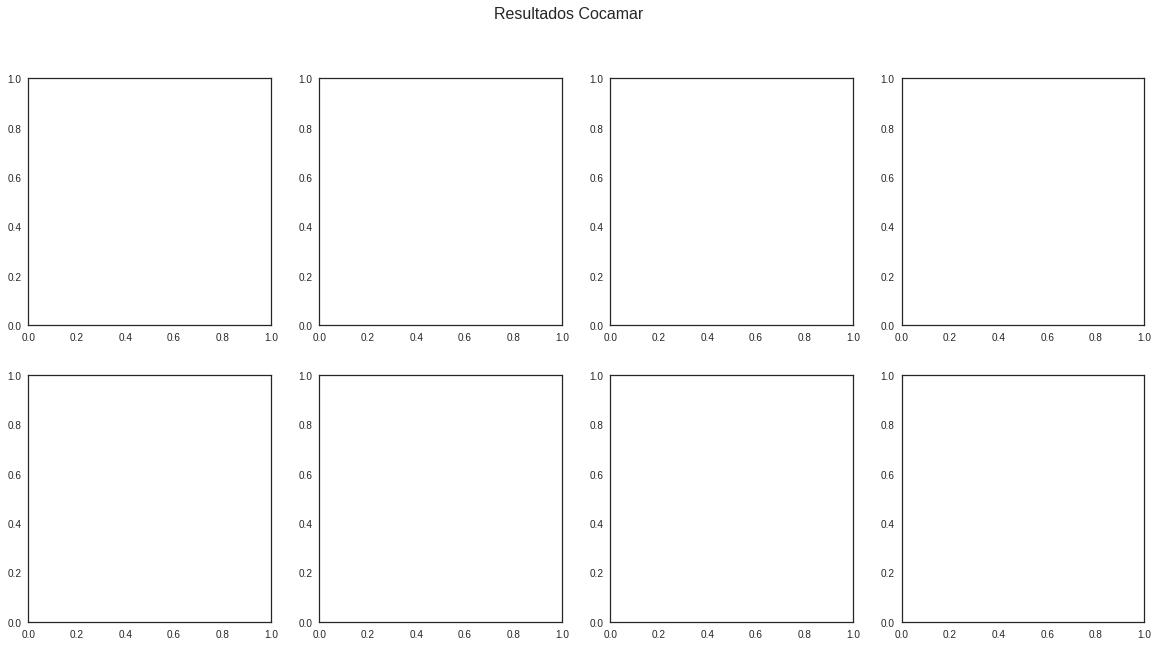

In [30]:
resultados = {"intervalo":[], "r2":[]}

if save_graph:
    fig,axes = plt.subplots(2,4, figsize=(20,10))
    if clima:
        fig.suptitle("Resultados Cocamar + Dados Climáticos ", fontsize=16)
    else:
        fig.suptitle("Resultados Cocamar", fontsize=16)    

for estadio in range(1,8):
    
    print("Estádios 1 -",estadio)
    est_col = 'e%d' % estadio
    
    
    if clima:
        X = t1.drop(t1.columns[list(range(3+estadio,10))],axis=1).reset_index(drop=True)
    else:
        X = t1.iloc[:,0:3+estadio].reset_index(drop=True)
        

    y = []
    for ind, row in X.iterrows():
        datainit = row["datprev"]
        perc = row[est_col]
        safra = row["safra"] 
        cult = row["codcult"]

        dataend = getPrazo(perc, safra, cult, t2)
        y.append(dataend)

    y = pd.Series(y)
    M = pd.concat([X,y.rename('datend')],axis=1)

    M["delta"] = (M.datend - M.datprev).dt.days
    M = M[M[est_col]!=100]
    M = M.drop(["datprev","datend"],axis=1)

    # ---------------------------------------------
    
    X = M.drop(["delta"],axis=1)    
    y = M[["delta"]]
    
    print(X)
    print(y)
    
    m = Model(X,y)
    #m.describe()
    #m.redux(pca_variance, graph=False)
    m.regression(folds=folds,printt=printt,graph=graph)
    
    if save_graph:
        predictions = m.pred
        r2 = np.round(m.reg[1],2)
        text = 'R2='+str(r2)
        
        if estadio-1 < 4:
            axes[0,estadio-1].scatter(m.testy,predictions,color='g')
            axes[0,estadio-1].set_title("1-"+str(estadio))
            axes[0,estadio-1].set_xlabel("True values")
            axes[0,estadio-1].set_ylabel("Predictions")
            axes[0,estadio-1].text(0.05, 0.95 , text, transform = axes[0,estadio-1].transAxes,
            verticalalignment= 'top', bbox={'boxstyle':'square','facecolor':'none','edgecolor':'black'})
        else:
            axes[1,estadio-5].scatter(m.testy,predictions,color='g')
            axes[1,estadio-5].set_title("1-"+str(estadio))
            axes[1,estadio-5].set_xlabel("True values")
            axes[1,estadio-5].set_ylabel("Predictions")
            axes[1,estadio-5].text(0.05, 0.95 , text, transform = axes[1,estadio-5].transAxes, 
            verticalalignment= 'top', bbox={'boxstyle':'square','facecolor':'none','edgecolor':'black'})
    
    resultados["intervalo"].append('1-'+str(estadio))
    resultados["r2"].append(m.reg[1])
    print("-------------------"*4)


if save_graph:
    fig.delaxes(ax=axes[1,3])
    image_name = "images/resultados-cocamar"
    if clima:
        image_name += "-clima"
    if pca:
        image_name += "-pca"+str(pca_variance)
    fig.savefig(image_name+".png")

        

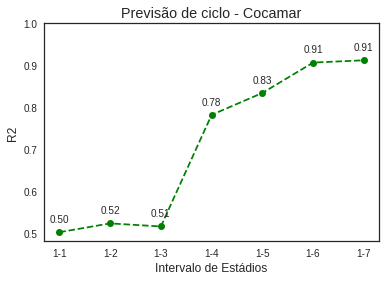

In [5]:
xs = resultados["intervalo"]
ys = resultados["r2"]
plt.plot(xs,ys,color='g',linestyle='dashed', marker='o')
for x,y in zip(xs,ys):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y),textcoords="offset points",
                 xytext=(0,10),ha='center')
plt.yticks(np.arange(0.5,1.05,0.1))
plt.xlabel("Intervalo de Estádios")
plt.ylabel("R2")
        
if save_graph:
    image_name = "images/r2-cocamar"
    title = "Previsão de ciclo - Cocamar"
    if clima:
        image_name += "-clima"
        title += " e Clima"
    if pca:
        image_name += "-pca"+str(pca_variance)
        title += " PCA"+str(pca_variance)
    plt.title(title)
    plt.savefig(image_name+".png")

